In [7]:
from canns.data.loaders import load_grid_data

grid_data = load_grid_data()

print(f"Keys: {list(grid_data.keys())}")
print(f"t: {grid_data['t'].shape}, x: {grid_data['x'].shape}, y: {grid_data['y'].shape}")
print(f"spike type: {type(grid_data['spike'])}")


Loaded grid_1: 172 neurons
Position data available: 238700 time points
Keys: ['spike', 't', 'x', 'y']
t: (238700,), x: (238700,), y: (238700,)
spike type: <class 'numpy.ndarray'>


In [8]:
from canns.analyzer import data

spike_cfg = data.SpikeEmbeddingConfig(
    smooth=True,
    speed_filter=False,
    min_speed=2.5,
)
spikes, xx, yy, tt = data.embed_spike_trains(grid_data, config=spike_cfg)

print(f"Embedded spikes: {spikes.shape}")


Embedded spikes: (238700, 172)


Computing persistent homology for real data...


Completed H1 computation: 100%|██████████| 718201/718201 [00:05<00:00, 134504.22columns/s]


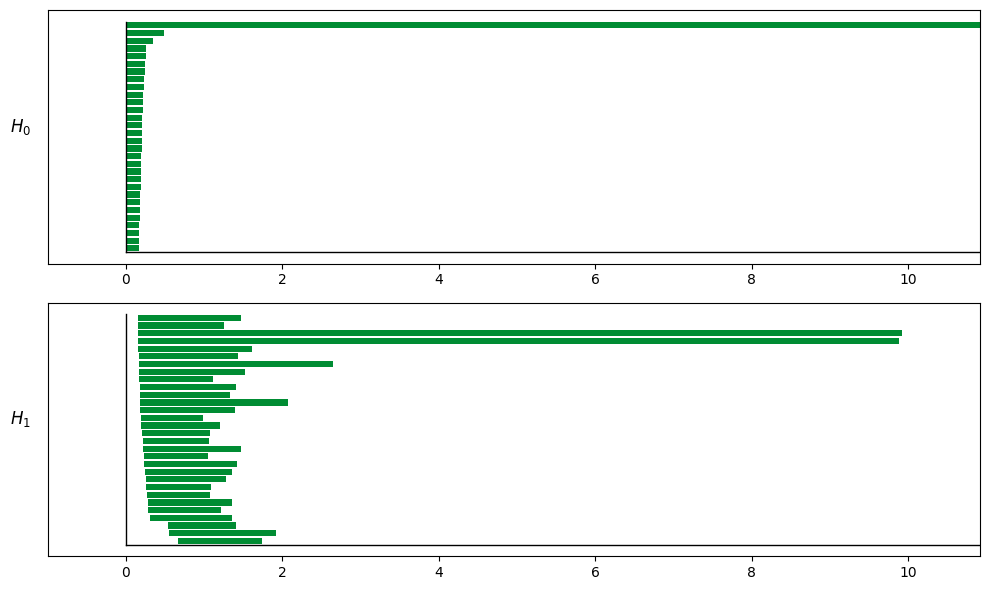

dict_keys(['coords', 'coordsbox', 'times', 'times_box', 'centcosall', 'centsinall'])


In [9]:
from canns.analyzer.visualization import PlotConfigs

# TDA
TDA_cfg = data.TDAConfig(maxdim=1, do_shuffle=False, show=True, progress_bar=True)
persistence = data.tda_vis(embed_data=spikes, config=TDA_cfg)

# Decode
grid_data_embedded = dict(grid_data)
grid_data_embedded["spike"] = spikes

decoding = data.decode_circular_coordinates_multi(
    persistence_result=persistence,
    spike_data=grid_data_embedded,
    num_circ=2,
)

print(decoding.keys())


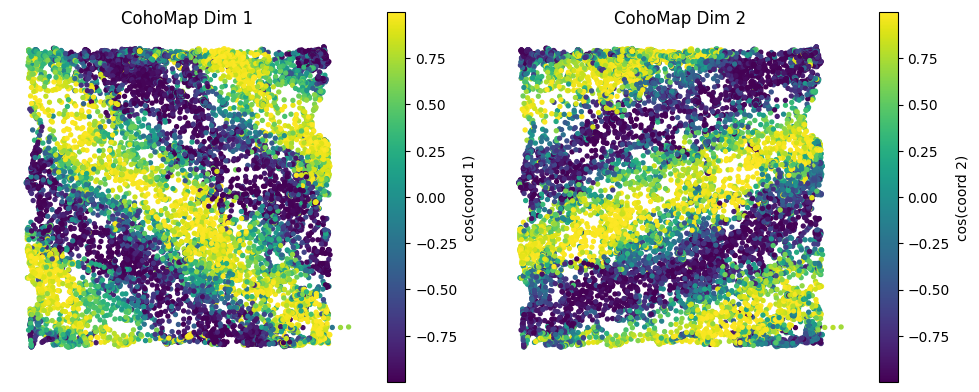

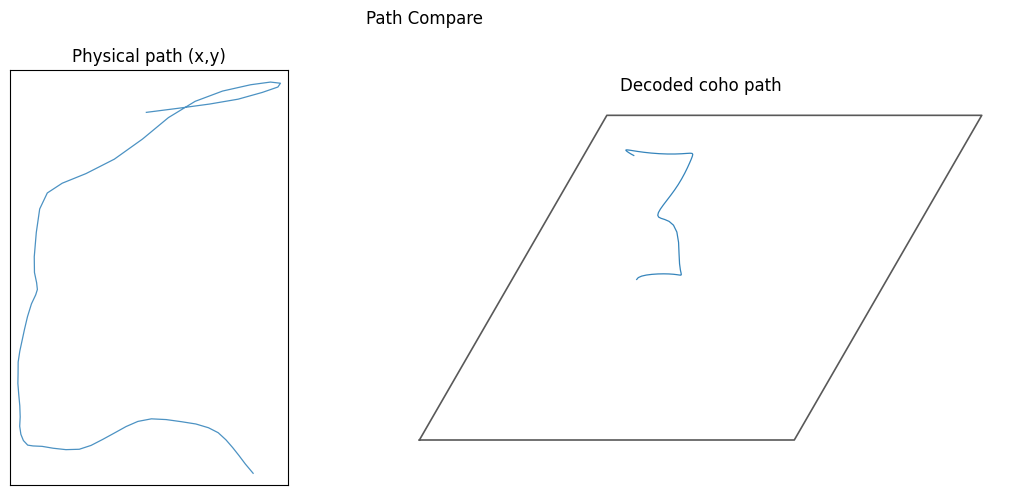

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Physical path (x,y)'}>,
        <Axes: title={'center': 'Decoded coho path'}>], dtype=object))

In [10]:
import numpy as np
from canns.analyzer.visualization import PlotConfigs

# CohoMap
cohomap_cfg = PlotConfigs.cohomap(show=True)

data.plot_cohomap_multi(
    decoding_result=decoding,
    position_data={"x": grid_data["x"], "y": grid_data["y"]},
    config=cohomap_cfg,
)

# PathCompare
coords = np.asarray(decoding.get("coords"))

t_use, x_use, y_use, coords_use, _ = data.align_coords_to_position_2d(
    t_full=np.asarray(grid_data["t"]).ravel()[200:260],
    x_full=np.asarray(grid_data["x"]).ravel()[200:260],
    y_full=np.asarray(grid_data["y"]).ravel()[200:260],
    coords2=coords,
    use_box=True,
    times_box=decoding.get("times_box", None),
    interp_to_full=True,
)

coords_use = data.apply_angle_scale(coords_use, "rad")

path_cfg = PlotConfigs.path_compare_2d(show=True)

data.plot_path_compare_2d(x_use, y_use, coords_use, config=path_cfg)


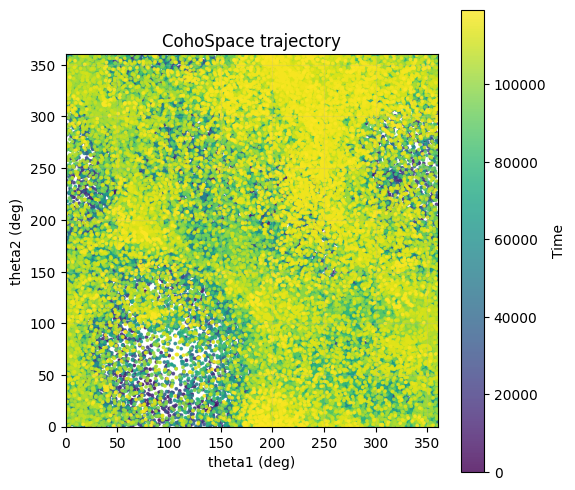

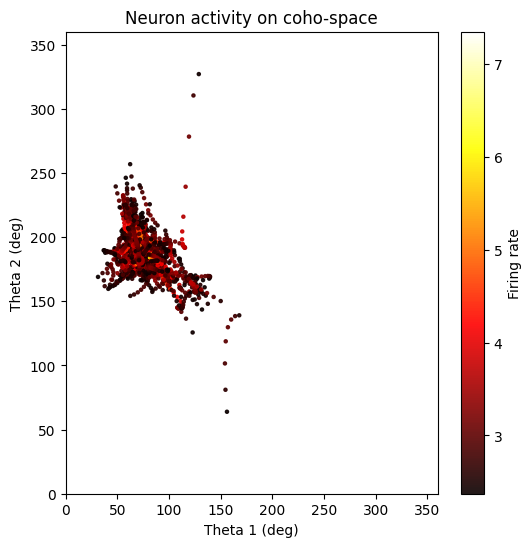

In [5]:
coords = np.asarray(decoding.get("coords"))
coordsbox = np.asarray(decoding.get("coordsbox"))

traj_cfg = PlotConfigs.cohospace_trajectory_2d(show=True)

data.plot_cohospace_trajectory_2d(
    coords=coords[:, :2],
    times=None,
    subsample=2,
    config=traj_cfg,
)

neuron_cfg = PlotConfigs.cohospace_neuron_2d(show=True)

fig = data.plot_cohospace_neuron_2d(
    coords=coordsbox[:, :2],
    activity=spikes,
    neuron_id=130,
    mode="fr",
    top_percent=1,
    config=neuron_cfg,
)


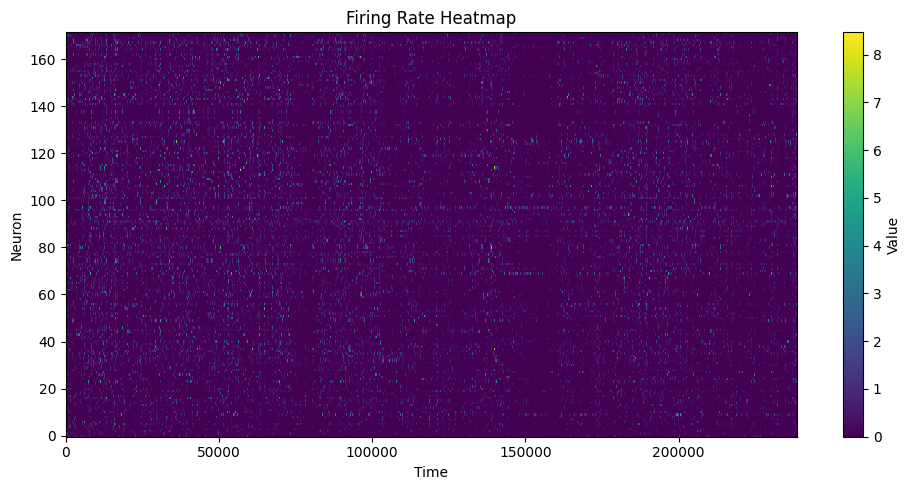

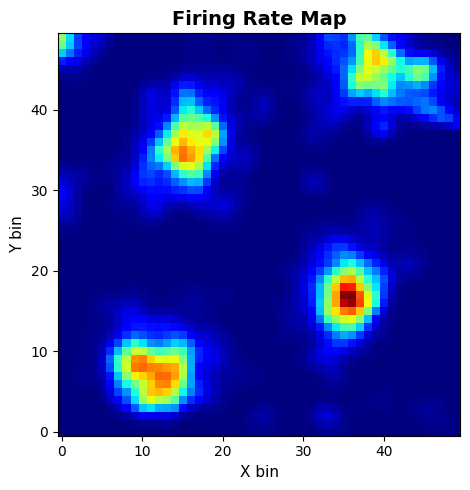

In [6]:
# FR Heatmap
heatmap = data.compute_fr_heatmap_matrix(spikes, transpose=True)
heatmap_cfg = PlotConfigs.fr_heatmap(show=True)

data.save_fr_heatmap_png(heatmap, config=heatmap_cfg)

# FRM
frm_res = data.compute_frm(
    spikes,
    grid_data["x"],
    grid_data["y"],
    neuron_id=130,
    bins=50,
    min_occupancy=1,
    smoothing=True,
    sigma=1.0,
    nan_for_empty=True,
)

frm_cfg = PlotConfigs.frm(show=True)

data.plot_frm(frm_res.frm, config=frm_cfg, dpi=200)
